<a href="https://colab.research.google.com/github/jeffveleze/age-gender-recognizer/blob/master/AgeGenderRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0

### Importing Libraries

In [0]:
# Helper libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import PIL

from PIL import Image
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Reading Data

In [119]:
# Define folder paths
folder_base_dir = '/content/drive/My Drive/Age-Gender-Recognizer-Dataset/'

# Create local folder data path 
folder_data_path = folder_base_dir + '**'
folder_data_path = os.path.expanduser(folder_data_path)

# Create array with folder image addresses
folder_addresses = glob.glob(folder_data_path)

# Initialize image_addresses empty list
image_addresses = []

print("Started looping folders")

# Used to count loaded folders
current_folders_loaded = 0
max_folders_loaded = 10

# Loop all the folders to get the addresses
for folder_address in folder_addresses:
  files_extension = '.jpg'

  # Create folder address path object
  folder_address_path = folder_address + '/*' + files_extension
  folder_address_path = os.path.expanduser(folder_address_path)

  # Create array with image addresses
  image_addresses_per_folder = glob.glob(folder_address_path)
  image_addresses += image_addresses_per_folder

  # Control the number of folders loadead
  current_folders_loaded += 1
  if current_folders_loaded == max_folders_loaded:
    break

print("Finished looping folders")

# Create function to extract data
def make_address_data(address):
  name_components = address.split('_')
  image_id = name_components[0].split('/')
  image_id = image_id[-1]
  birth_date = name_components[1]
  publish_date = name_components[2].replace(files_extension, '')
  birth_date_year = int(birth_date.split('-')[0])

  # Add a try-except when casting the publish_date
  try:
      publish_date_year = int(publish_date)
  except ValueError:
      # Handle the exception
      return (-1, -1, -1, -1, -1)

  age = publish_date_year - birth_date_year

  return (image_id, birth_date, birth_date_year, publish_date_year, age)

# Create initial values
RESIZED_WIDTH = 200
RESIZED_HEIGHT = 200
addresses = []
image_ids = []
birth_dates = []
birth_date_years = []
publish_date_years = []
ages = []
data_extraction_fails = 0

print("Started filling lists")

for address in image_addresses:
  image_id, birth_date, birth_date_year, publish_date_year, age = make_address_data(address)

  # Count filtered images bcz of wrong name
  if image_id == -1 and birth_date == -1:
    data_extraction_fails += 1

  if age > 0 and age < 100:

    # Appending path taken values
    addresses.append(address)
    image_ids.append(image_id)
    birth_dates.append(birth_date)
    birth_date_years.append(birth_date_year)
    publish_date_years.append(publish_date_year)
    ages.append(age)

print("Finished filling lists")
print("Files with wrong names:", data_extraction_fails)

np.array(ages).shape

Started looping folders
Finished looping folders
Started filling lists
Finished filling lists
Files with wrong names: 10


(5996,)

### Exploring Data

In [120]:
# Create dictionary arrays
images_dictionary = {'image_address': addresses, 'age' : ages}
images_data_frame = pd.DataFrame(images_dictionary)

# Visualize dataframe
images_data_frame.head()

,image_address,age
0,/content/drive/My Drive/Age-Gender-Recognizer-...,48
1,/content/drive/My Drive/Age-Gender-Recognizer-...,24
2,/content/drive/My Drive/Age-Gender-Recognizer-...,56
3,/content/drive/My Drive/Age-Gender-Recognizer-...,32
4,/content/drive/My Drive/Age-Gender-Recognizer-...,24


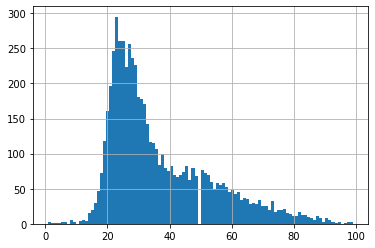

In [121]:
images_data_frame['age'].hist(bins = 100)            

In [122]:
images_data_frame.describe()

,age
count,5996.000000
mean,36.976818
std,16.594199
min,1.000000
25%,25.000000
50%,31.000000
75%,47.000000
max,99.000000


### Splitting Data

In [123]:
# Separating X and Y columns
X_df = images_data_frame['image_address'].copy()
Y_df = images_data_frame['age'].copy()

# Splitting train and test data
train_image_addresses, test_image_addresses, train_labels, test_labels = train_test_split(X_df, 
                                                                                           Y_df, 
                                                                                           test_size = 0.1, 
                                                                                           random_state = 2)

# Creating train and test dataframes
train_dictionary = {'train_image_addresses': train_image_addresses, 'train_labels' : train_labels}
test_dictionary = {'test_image_addresses': test_image_addresses, 'test_labels' : test_labels}
train_df = pd.DataFrame(train_dictionary)
test_df = pd.DataFrame(test_dictionary)

# Verifying correct shape
print(train_df.shape)
print(test_df.shape)

(5396, 2)
(600, 2)


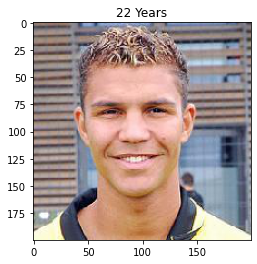

In [124]:
# Define random number to display image
image_index = 200

# Transforming images into matrixes and applying resizing
train_image_addresses_list = train_image_addresses.tolist()
train_labels_list = train_labels.tolist()
image = Image.open(train_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(train_labels_list[image_index]) + " Years")
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

### Creating Generators

In [0]:
# Defining hyperparameters
hyperparams = {'dense' : 4, 
               'units': 256, 
               'activation' : 'relu', 
               'dropout': 0.15}

# Defining epochs and batch_size
batch_size = 32
epochs = 30           

In [0]:
# Generators for our data
train_image_generator = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.15
)

test_image_generator = ImageDataGenerator(rescale = 1./255)

In [127]:
# Load images from the disk, applies rescaling and resizes for train, validation and test
train_data_gen = train_image_generator.flow_from_dataframe(dataframe = train_df,
                                                           x_col = 'train_image_addresses',
                                                           y_col = 'train_labels',
                                                           batch_size = batch_size,
                                                           shuffle = False,
                                                           target_size = (RESIZED_WIDTH, RESIZED_HEIGHT),
                                                           class_mode = 'raw',
                                                           subset = 'training')

validation_data_gen = train_image_generator.flow_from_dataframe(dataframe = train_df,
                                                           x_col = 'train_image_addresses',
                                                           y_col = 'train_labels',
                                                           batch_size = batch_size,
                                                           shuffle = False,
                                                           target_size = (RESIZED_WIDTH, RESIZED_HEIGHT),
                                                           class_mode = 'raw',
                                                           subset = 'validation')

test_data_gen = test_image_generator.flow_from_dataframe(dataframe = test_df,
                                                         x_col = 'test_image_addresses',
                                                         y_col = 'test_labels',
                                                         batch_size = batch_size,
                                                         shuffle = False,
                                                         target_size = (RESIZED_WIDTH, RESIZED_HEIGHT),
                                                         class_mode = 'raw')

train_df_size = train_df.shape[0]

Found 4587 validated image filenames.
Found 809 validated image filenames.
Found 600 validated image filenames.


### Functional Model

In [0]:
# Adding function to create functional model
def make_functional_model(hyperparams):

  inputs = tf.keras.Input(shape=(RESIZED_WIDTH, RESIZED_HEIGHT, 3))
  x1 = tf.keras.layers.Flatten()(inputs)
  x = x1

  units = hyperparams['units']
  
  # Inserting new layers 
  while units >= 8:
    x = tf.keras.layers.Dense(units, activation = hyperparams['activation'])(x)
    x = tf.keras.layers.Dropout(hyperparams['dropout'])(x)
    units /= 2

  x2 = tf.keras.layers.Dense(32)(x1)
  x = tf.keras.layers.Concatenate()([x, x2])
  outputs = tf.keras.layers.Dense(1)(x)

  functional_model = tf.keras.Model(inputs = inputs, outputs = outputs)
  
  return functional_model

In [0]:
# Creating model
functional_model = make_functional_model(hyperparams)

# Compiling models
functional_model.compile(optimizer = 'adam',
                         loss = 'mse',
                         metrics = ['mae'])

functional_model.summary()

In [0]:
# Load the model
# functional_model = keras.models.load_model("functional_model")

# fm_history = functional_model.his

In [0]:
# Training the model
fm_history = functional_model.fit_generator(
    train_data_gen,
    steps_per_epoch = train_df_size // batch_size,
    validation_data = validation_data_gen,
    validation_steps = train_df_size // batch_size,
    epochs = epochs
)

In [131]:
# Save the Model
functional_model.save("functional_model")

INFO:tensorflow:Assets written to: functional_model/assets


In [132]:
# Print resulting functional_model metrics for train
train_mse_fm, train_mae_fm = functional_model.evaluate_generator(train_data_gen)

print("Train MSE Functional Model: {}".format(train_mse_fm))
print("Train MAE Functional Model: {}".format(train_mae_fm))

Train MSE Functional Model: 197.0209085146586
Train MAE Functional Model: 10.596124649047852


In [133]:
# Print resulting functional_model metrics for test
test_mse_fm, test_mae_fm = functional_model.evaluate_generator(test_data_gen)

print("Test MSE Functional Model: {}".format(test_mse_fm))
print("Test MAE Functional Model: {}".format(test_mae_fm))

Test MSE Functional Model: 241.31686843068977
Test MAE Functional Model: 11.877877235412598


In [134]:
# Predicting with test data
predicted_labels_fm = functional_model.predict_generator(test_data_gen)

# Calculating some more metrics
test_mse_fm = mean_squared_error(test_labels, predicted_labels_fm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_fm))

test_mae_fm = mean_absolute_error(test_labels, predicted_labels_fm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_fm))

test_r2_fm = r2_score(test_labels, predicted_labels_fm)
print("R_2 = {:.3f}".format(test_r2_fm))

Mean Square Error (MSE)= 240.56
Mean Absolute Error (MAE)= 11.88
R_2 = 0.035


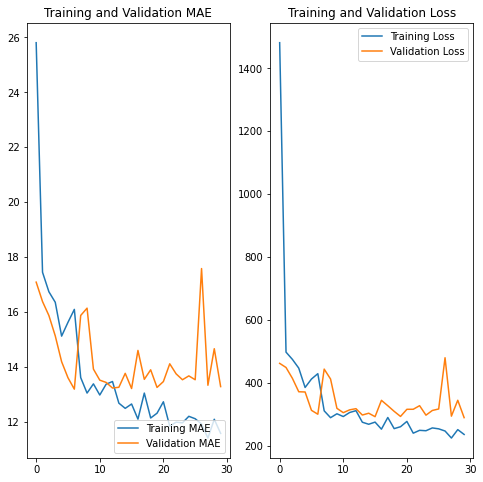

In [135]:
# Visualizing MAE and Loss for Training and Validation Sets
mae = fm_history.history['mae']
val_mae = fm_history.history['val_mae']

loss = fm_history.history['loss']
val_loss = fm_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label = 'Training MAE')
plt.plot(epochs_range, val_mae, label = 'Validation MAE')
plt.legend(loc = 'lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

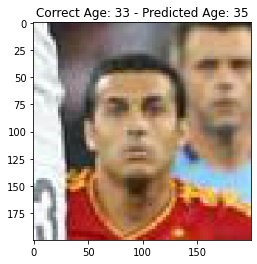

In [136]:
# Visualizing model predictions

# Define random number to display image
image_index = 200

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()
predicted_test_labels_list = predicted_labels_fm.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_test_labels_list[image_index][0]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

### Sequential Model

In [0]:
# Adding function to create sequential model
def make_sequential_model(hyperparams):

  layers_list = []
  layers_list.append(
      tf.keras.layers.Flatten(input_shape=(RESIZED_WIDTH, RESIZED_HEIGHT, 3))
  )

  units = hyperparams['units']
  
  # Inserting new layers 
  while units >= 8:
    layers_list.append(tf.keras.layers.Dense(units, activation = hyperparams['activation']))
    layers_list.append(tf.keras.layers.Dropout(hyperparams['dropout']))
    units /= 2

  # No activation function is used for the output layer because it's a 
  # regression problem and we are interested in predicting numerical values 
  # directly without transform.
  layers_list.append(tf.keras.layers.Dense(1))
  sequential_model = tf.keras.models.Sequential(layers_list)

  return sequential_model

In [0]:
# Creating model
sequential_model = make_sequential_model(hyperparams)

# Compiling model
sequential_model.compile(optimizer = 'adam',
                         loss = 'mse',
                         metrics = ['mae'])

sequential_model.summary()

In [139]:
# Training the model
sm_history = sequential_model.fit_generator(
    train_data_gen,
    steps_per_epoch = train_df_size // batch_size,
    validation_data = validation_data_gen,
    validation_steps = train_df_size // batch_size,
    epochs = epochs
)

Epoch 1/30
168/168 [==============================] - 42s 253ms/step - loss: 990.5055 - mae: 25.2591 - val_loss: 585.8480 - val_mae: 18.5871
Epoch 2/30
168/168 [==============================] - 43s 254ms/step - loss: 709.7539 - mae: 20.8109 - val_loss: 400.5548 - val_mae: 14.4791
Epoch 3/30
168/168 [==============================] - 43s 258ms/step - loss: 563.1254 - mae: 18.2939 - val_loss: 539.5258 - val_mae: 17.4907
Epoch 4/30
168/168 [==============================] - 43s 256ms/step - loss: 500.6514 - mae: 17.2505 - val_loss: 408.0845 - val_mae: 14.5671
Epoch 5/30
168/168 [==============================] - 43s 254ms/step - loss: 486.4145 - mae: 17.0300 - val_loss: 494.4609 - val_mae: 16.5380
Epoch 6/30
168/168 [==============================] - 43s 254ms/step - loss: 466.2561 - mae: 16.5042 - val_loss: 545.3372 - val_mae: 17.7390
Epoch 7/30
168/168 [==============================] - 42s 252ms/step - loss: 440.5260 - mae: 16.0606 - val_loss: 596.7842 - val_mae: 18.9176
Epoch 8/30
16

In [149]:
# Save the Model
sequential_model.save("sequential_model")

INFO:tensorflow:Assets written to: sequential_model/assets


In [141]:
# Print resulting sequential_model metrics for train
train_mse_sm, train_mae_sm = sequential_model.evaluate_generator(train_data_gen)

print("Train MSE Sequential Model: {}".format(train_mse_sm))
print("Train MAE Sequential Model: {}".format(train_mae_sm))

Train MSE Sequential Model: 284.90108585357666
Train MAE Sequential Model: 12.77938461303711


In [142]:
# Print resulting sequential_model metrics for test
test_mse_sm, test_mae_sm = sequential_model.evaluate_generator(test_data_gen)

print("Test MSE Sequential Model: {}".format(test_mse_sm))
print("Test MAE Sequential Model: {}".format(test_mae_sm))

Test MSE Sequential Model: 253.83407432154604
Test MAE Sequential Model: 12.054492950439453


In [143]:
# Predicting with test data
predicted_labels_sm = sequential_model.predict_generator(test_data_gen)

# Calculating some more metrics
test_mse_sm = mean_squared_error(test_labels, predicted_labels_sm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_sm))

test_mae_sm = mean_absolute_error(test_labels, predicted_labels_sm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_sm))

test_r2_sm = r2_score(test_labels, predicted_labels_sm)
print("R_2 = {:.3f}".format(test_r2_sm))

Mean Square Error (MSE)= 252.49
Mean Absolute Error (MAE)= 12.05
R_2 = -0.013


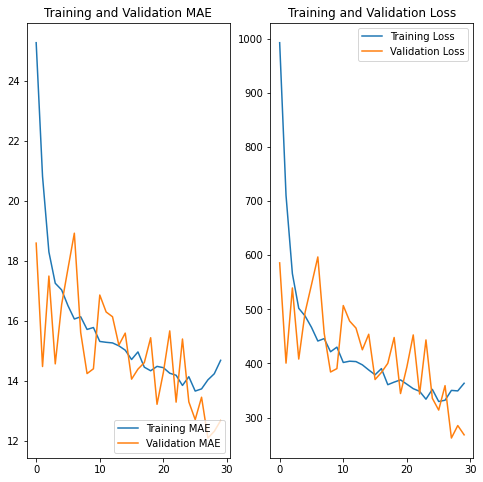

In [144]:
# Visualizing MAE and Loss for Training and Validation Sets
mae = sm_history.history['mae']
val_mae = sm_history.history['val_mae']

loss = sm_history.history['loss']
val_loss = sm_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label = 'Training MAE')
plt.plot(epochs_range, val_mae, label = 'Validation MAE')
plt.legend(loc = 'lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

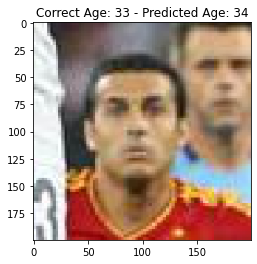

In [145]:
# Visualizing model predictions

# Define random number to display image
image_index = 200

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()
predicted_test_labels_list = predicted_labels_sm.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_test_labels_list[image_index][0]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

###CNN Model

In [0]:
# Define function to create CNN

def create_cnn(width, height, depth, filters = (16, 32, 64)):
	inputShape = (height, width, depth)
	chanDim = -1

	# Define the model input
	inputs = Input(shape = inputShape)

	# Loop over the number of filters
	for (i, f) in enumerate(filters):
	
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs

		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding = "same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis = chanDim)(x)
		x = MaxPooling2D(pool_size = (2, 2))(x)
		x = Dropout(0.15)(x)
	
	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(512)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis = chanDim)(x)
	# x = Dropout(0.15)(x)

	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(16)(x)
	x = Activation("relu")(x)

	x = Dense(1, activation = "linear")(x)
	
	# construct the CNN
	model = Model(inputs, x)

	# return the CNN
	return model

  # model = Sequential([
  #   Conv2D(16, 3, padding='same', activation='relu', input_shape=(width, height, 3)),
  #   MaxPooling2D(),
  #   Conv2D(32, 3, padding='same', activation='relu'),
  #   MaxPooling2D(),
  #   Conv2D(64, 3, padding='same', activation='relu'),
  #   MaxPooling2D(),
  #   Flatten(),
  #   # Dense(512, activation='relu'),
  #   Dense(512),
  #   Dense(1)
  # ])

  # return model

In [0]:
# Creating CNN
cnn_model = create_cnn(RESIZED_WIDTH, RESIZED_HEIGHT, 3)

# Compile model
cnn_model.compile(optimizer = 'adam',
                  loss = 'mse',
                  metrics = ['mae'])

cnn_model.summary()

In [0]:
# Training the model
cnnm_history = cnn_model.fit_generator(
    train_data_gen,
    steps_per_epoch = train_df_size // batch_size,
    validation_data = validation_data_gen,
    validation_steps = train_df_size // batch_size,
    epochs = epochs
)

In [150]:
# Save the Model
cnn_model.save("cnn_model")

INFO:tensorflow:Assets written to: cnn_model/assets


In [151]:
# Print resulting cnn_model metrics for train
train_mse_cnnm, train_mae_cnnm = cnn_model.evaluate_generator(train_data_gen)

print("Train MSE CNN Model: {}".format(train_mse_cnnm))
print("Train MAE CNN Model: {}".format(train_mae_cnnm))

Train MSE CNN Model: 58.07742424143685
Train MAE CNN Model: 4.753961563110352


In [152]:
# Print resulting cnn_model metrics for test
test_mse_cnnm, test_mae_cnnm = cnn_model.evaluate_generator(test_data_gen)

print("Test MSE CNN Model: {}".format(test_mse_cnnm))
print("Test MAE CNN Model: {}".format(test_mae_cnnm))

Test MSE CNN Model: 201.62556859066612
Test MAE CNN Model: 10.93829345703125


In [153]:
# Predicting with test data
predicted_labels_cnnm = cnn_model.predict_generator(test_data_gen)

# Calculating some more metrics
test_mse_cnnm = mean_squared_error(test_labels, predicted_labels_cnnm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_cnnm))

test_mae_cnnm = mean_absolute_error(test_labels, predicted_labels_cnnm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_cnnm))

test_r2_cnnm = r2_score(test_labels, predicted_labels_cnnm)
print("R_2 = {:.3f}".format(test_r2_cnnm))

Mean Square Error (MSE)= 201.14
Mean Absolute Error (MAE)= 10.94
R_2 = 0.193


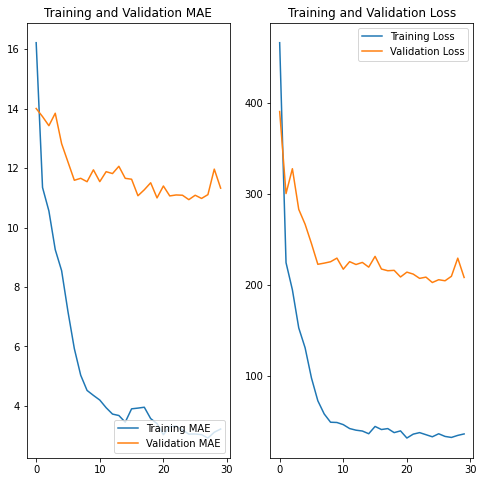

In [154]:
# Visualizing MAE and Loss for Training and Validation Sets
mae = cnnm_history.history['mae']
val_mae = cnnm_history.history['val_mae']

loss = cnnm_history.history['loss']
val_loss = cnnm_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label = 'Training MAE')
plt.plot(epochs_range, val_mae, label = 'Validation MAE')
plt.legend(loc = 'lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

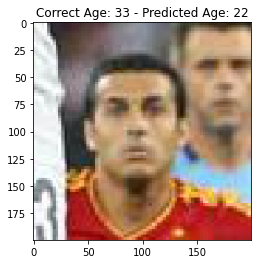

In [156]:
# Visualizing model predictions

# Define random number to display image
image_index = 200

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()
predicted_test_labels_list = predicted_labels_cnnm.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_test_labels_list[image_index][0]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()